In [19]:
%load_ext autoreload
%autoreload 2

import util as yu
from util import *
import util_moments as yum

yu.setpath('compareSVD')

enss=['b','c','d']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
basepath=f'/p/project1/ngff/li47/code/projectData/05_moments/'
def mom2num(mom):
    moms=yu.mom2moms(list(mom))
    return len(moms)
def extract2pt(ens,n2qpp1):
    inpath=f'{basepath}{yu.ens2full[ens]}/data_merge/'
    n2q,n2p,n2p1=n2qpp1
    path=f'{inpath}conn_2pt.h5'
    
    tf2c2pta,tf2c2ptb={},{}
    with h5py.File(path) as f:
        moms=yu.moms2list(f['moms'])
        msqs=[yu.mom2msq(mom) for mom in moms]
        
        # sink
        inds=np.where(np.array(msqs)==n2p1)[0]
        Ns=[mom2num(moms[ind]) for ind in inds]
        weights=np.array(Ns)/np.sum(Ns)
        for tfstr in f['data'].keys():
            tf=int(tfstr) 
            t=np.real(f['data'][tfstr][:])
            t=np.sum([t[:,:,ind]*weights[i] for i,ind in enumerate(inds)],axis=0)
            t=yu.jackknife(t)
            tf2c2pta[tf]=t
        
        # source
        inds=np.where(np.array(msqs)==n2p)[0]
        Ns=[mom2num(moms[ind]) for ind in inds]
        weights=np.array(Ns)/np.sum(Ns)
        for tfstr in f['data'].keys():
            tf=int(tfstr) 
            t=np.real(f['data'][tfstr][:])
            t=np.sum([t[:,:,ind]*weights[i] for i,ind in enumerate(inds)],axis=0)
            t=yu.jackknife(t)
            tf2c2ptb[tf]=t

    return tf2c2pta,tf2c2ptb

[0.+0.0486923j  0.-0.00080652j 0.+0.00322608j]
0.0486922985397515j
<KeysViewHDF5 ['j+;conn_10', 'j+;conn_12', 'j+;conn_14', 'j+;conn_16', 'j+;conn_18', 'j+;conn_20', 'j+;conn_8', 'j-;conn_10', 'j-;conn_12', 'j-;conn_14', 'j-;conn_16', 'j-;conn_18', 'j-;conn_20', 'j-;conn_8']>


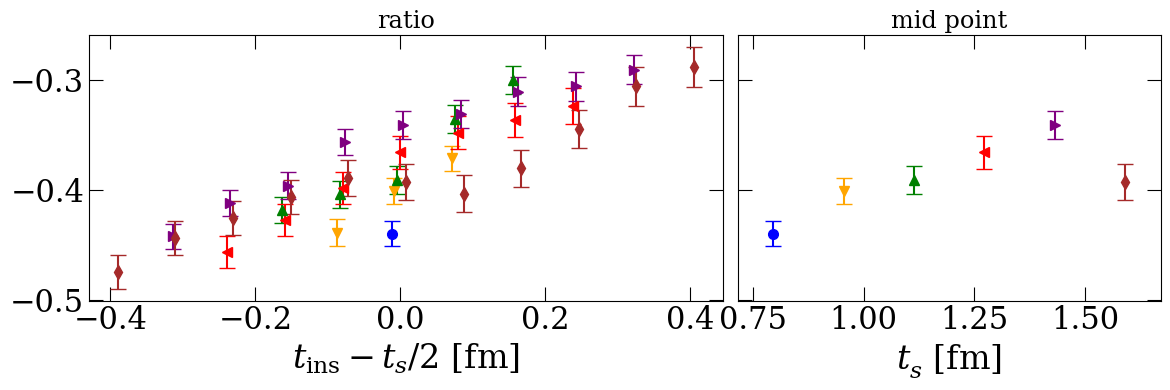

In [ ]:
ens='b'
m=938/yu.ens2aInv[ens]
pvec=np.array([0,0,1])*2*np.pi/yu.ens2NL[ens]
pvec1=np.array([0,0,0])*2*np.pi/yu.ens2NL[ens]
proj='Px'; insert='ty'
proj='P0'; insert='tz'
t=yum.ME2FF(m,pvec,pvec1,proj,insert)
factor=t[0]
print(t)
print(factor)

tf2c2pta,tf2c2ptb=extract2pt(ens,(2,2,0))

path='/p/project1/ngff/li47/code/projectData/05_moments/cB211.072.64/data_merge/conn_0,0,0,0,1,1.h5'
with h5py.File(path) as f:
    print(f['data'].keys())
    
    tf2ratio={}
    for key in f['data'].keys():
        j,tf=key.split('_'); tf=int(tf)
        if j not in ['j+;conn']:
            continue
        t=f['data'][key][:]
        t=t[:,:,0,yum.projs.index(proj),yum.inserts.index(insert)]
        t=yu.jackknife(t)
        c3pt=np.real(t/factor)
        c2pta=tf2c2pta[tf]; c2ptb=tf2c2ptb[tf]
        ratio=c3pt/np.sqrt(
            c2pta[:,tf:tf+1]*c2ptb[:,tf:tf+1]*\
            c2pta[:,:tf+1][:,::-1]/c2pta[:,:tf+1]*\
            c2ptb[:,:tf+1]/c2ptb[:,:tf+1][:,::-1]
        )
        tf2ratio[tf]=ratio
        
        
list_dic=[{
    'base:[tf2ratio,fits_band,fits_const,fits_sum,fits_2st]':[tf2ratio,None,None,None,None],
    'rainbow:[tfmin,tfmax,tcmin,dt]':[None,None,5,None],
    'xunit':yu.ens2a[ens],
}]
fig,axs=yu.makePlot_3pt(list_dic,shows=['rainbow','midpoint'])
yu.finalizePlot()



0.3255074327187069 0.6067193326815701


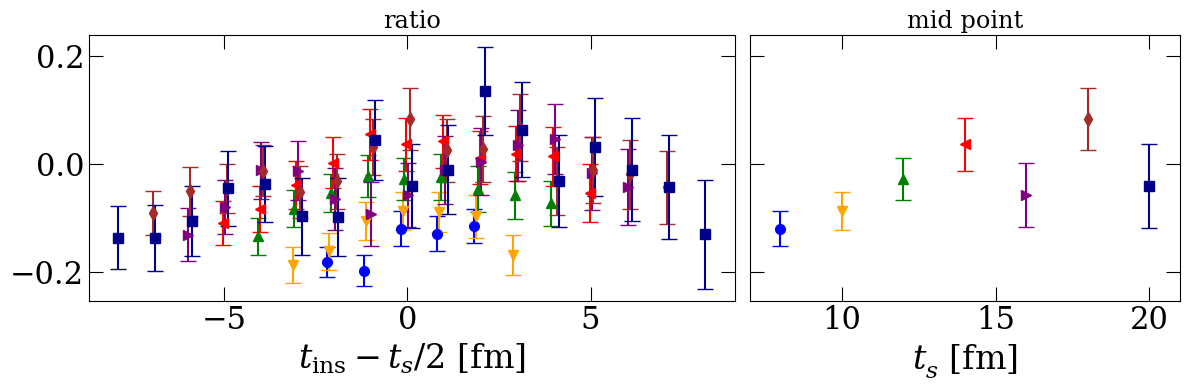

In [34]:
print(yum.n2qpp12Q2((6,6,0),'b'),yum.n2qpp12Q2((12,12,0),'b'))

ens='b'
def load(ens,msq):
    path='/p/project1/ngff/li47/code/projectData/05_moments/doSVD/'
    key2tf2ratio={}
    with h5py.File(f'{path}conn_{ens}_{msq},{msq},0.h5') as f:
        for case in f.keys():
            for key in f[case].keys():
                ff,j,tf=key.split('_'); tf=int(tf)
                
                key_new=(case,ff,j)
                if key_new not in key2tf2ratio:
                    key2tf2ratio[key_new]={}
                
                key2tf2ratio[key_new][tf]=f[case][key][:]
                
    return key2tf2ratio
key2tf2ratio=load(ens,6)

tf2ratio=key2tf2ratio[('equal','B20','j+;conn')]
fig,axs=yu.makePlot_3pt_rainbow(tf2ratio,tcmin=2)
# axs[0,0].set_ylim([-0.1,0.1])
# axs[0,0].set_yticks([-0.1,-0.05,0,0.05,0.1])
yu.finalizePlot()

In [ ]:
key2bare={}

overwrite=False
def createDic(key):
    ens,j=key
    gett=lambda t:round(t/yu.ens2a[ens])
    def get_tfs(tmin,tmax,dt=1):
        return range(gett(tmin),gett(tmax),dt)
    lat_a=yu.ens2a[ens]
    
    # tfmins_1st=get_tfs(0.5,1.2)
    # tcmins_1st=get_tfs(2*lat_a,0.5)
    # tfmins_2st=get_tfs(0.5,0.8)
    # tcmins_2st=get_tfs(2*lat_a,0.3)
    
    tfmins_2st=range(8,ens2tfs_conn[ens][-1],2); tcmins_2st=range(2,ens2tfs_conn[ens][-1]//2-1)
    
    tf2ratio=key2tf2ratio[(ens,j)]
    # fits_band=yu.doFits_3pt_band(tf2ratio,tcmins_1st,corrQ=False,label=f'{ens}_{j}_fits_band',overwrite=overwrite)
    # fit_band_WA=yu.doWA_band(fits_band,tf_min=gett(0.8),tf_max=gett(1.3),tcmin=max(gett(0.2),2),corrQ=False)
    # fits_const=yu.doFits_3pt_1st(tf2ratio,tfmins_1st,tcmins_1st,symmetrizeQ=True,label=f'{ens}_{j}_fits_const',overwrite=overwrite)
    # fit_const_MA=yu.doMA_3pt(fits_const,tfmin_min=gett(0.8),tcmin_min=3)
    fits_sum=yu.doFits_3pt_sum(tf2ratio,tfmins_2st,tcmins_2st,label=f'{ens}_{j}_fits_sum',overwrite=overwrite)
    # fit_sum_MA=yu.doMA_3pt(fits_sum,tcmin_min=gett(0.2))
    fits_2st=yu.doFits_3ptSym_2st2step(tf2ratio,tfmins_2st,tcmins_2st,pars_jk_meff2st=ens2pars_jk_meff2st[ens],symmetrizeQ=True,label=f'{ens}_{j}')
    fit_2st_MA=yu.doMA_3pt(fits_2st,tcmin_min=gett(0.2))
    
    key2bare[(ens,j)]=fit_2st_MA[0][:,0]

    dic={
        'base:[tf2ratio,fits_band,fits_const,fits_sum,fits_2st]':[tf2ratio,None,None,fits_sum,fits_2st],
        'rainbow:[tfmin,tfmax,tcmin,dt]':[None,None,2,None],
        # 'fit_band:[tfmin,tfmax,tcmin_min,tcmin_max]':[gett(0.5),gett(1.3),None,None],
        # 'fit_band_WA':fit_band_WA,
        # 'fit_const:[tfmin_min,tfmin_max,tcmin_min,tcmin_max]':[None,None,None,None],
        # 'fit_const_MA':fit_const_MA,
        'fit_sum:[tfmin_min,tfmin_max,tcmin_min,tcmin_max]':[None,None,2,5],
        # 'fit_sum_MA':fit_sum_MA,
        'fit_2st:[tfmin_min,tfmin_max,tcmin_min,tcmin_max]':[None,None,2,5],
        'fit_2st_MA':fit_2st_MA,
        'fit_2st_rainbow_midpoint:[pars_jk_meff2st]':ens2pars_jk_meff2st[ens],
        'xunit':yu.ens2a[ens],
    }
    return dic

js_plt=['j+;conn','j-;conn']; enss_plt=enss

for ij,j in enumerate(js_plt):
    print(f'{ij}/{len(js_plt)}',j,end='                 \r')
    keys=[(ens,j) for ens in enss_plt]

    list_dic=[createDic(key) for key in keys]

    fig,axs=yu.makePlot_3pt(list_dic,shows=['rainbow','midpoint','fit_2st','fit_2st_prob','fit_sum'])
    yu.addRowHeader(axs,[yu.ens2label[ens] for ens in enss_plt])
    yu.finalizePlot(j)
    
# yu.save_pkl_reg('key2bare_conn',key2bare)